In [ ]:
!pip install accelerate -U
!pip install transformers[torch]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import EvalPrediction

In [108]:
df = pd.read_csv("IMDB_Dataset.csv")

In [109]:
df = pd.read_csv("IMDB_Dataset.csv")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Average Review Length: 1309.43102 characters
Average Review Length: 231.15694 words


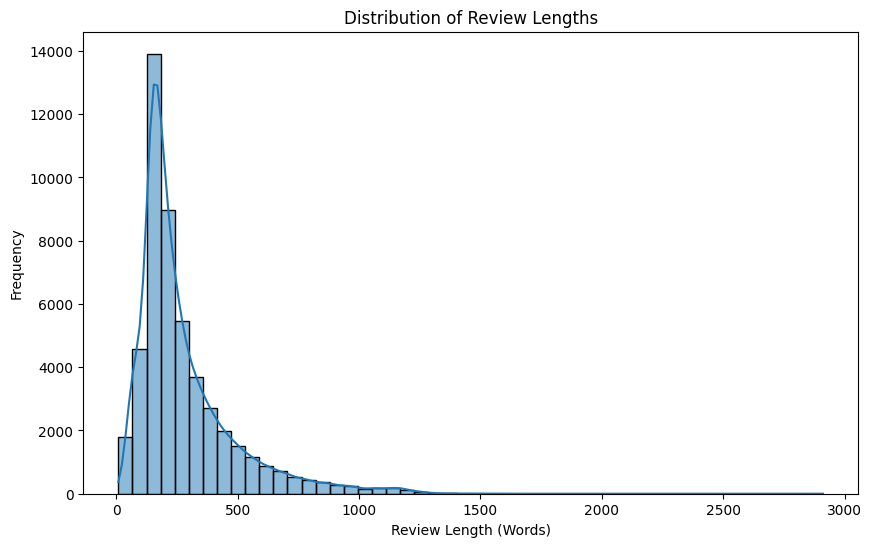

Most Common Words:
br: 201951
movie: 85070
film: 76919
one: 51828
like: 39183
good: 28767
would: 26475
even: 24780
time: 23481
really: 23024


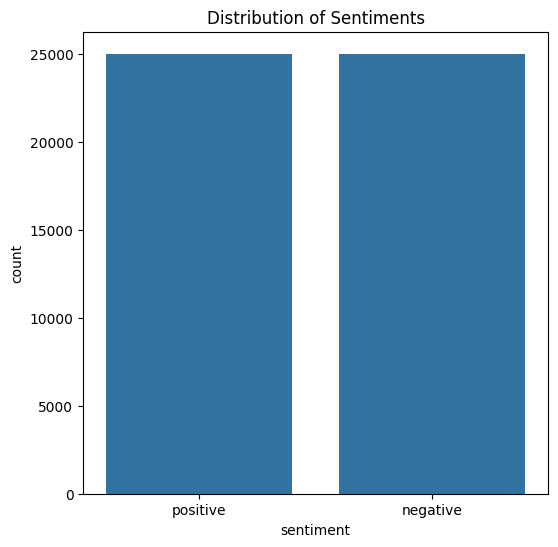

Vocabulary Richness (Type-Token Ratio): 0.01652384557618473


In [113]:
nltk.download('punkt')
nltk.download('stopwords')

# Load the dataset
df = pd.read_csv("IMDB_Dataset.csv")

# Preprocess and tokenize reviews
df['review_length'] = df['review'].apply(lambda x: len(word_tokenize(x)))
df['review_word_count'] = df['review'].apply(lambda x: len(x.split()))

# Calculate basic statistics
average_length_chars = df['review'].apply(len).mean()
average_length_words = df['review_word_count'].mean()

print(f"Average Review Length: {average_length_chars} characters")
print(f"Average Review Length: {average_length_words} words")

# Distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')
plt.show()

# Word frequency distribution excluding stopwords
all_words = ' '.join(df['review']).lower()
tokens = word_tokenize(all_words)
words = [word for word in tokens if word.isalpha()]  # Remove punctuation
stop_words = set(stopwords.words('english'))
words = [word for word in words if not word in stop_words]

# Most common words
from collections import Counter
word_counter = Counter(words)
most_common_words = word_counter.most_common(10)
print("Most Common Words:")
for word, count in most_common_words:
    print(f"{word}: {count}")

# Sentiment distribution
plt.figure(figsize=(6, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.show()

# Vocabulary richness (Type-Token Ratio)
unique_words = len(set(words))
total_words = len(words)
type_token_ratio = unique_words / total_words
print(f"Vocabulary Richness (Type-Token Ratio): {type_token_ratio}")


In [115]:
df = pd.read_csv("IMDB_Dataset.csv")

# Add a new column 'Category' for binary classification
df["Category"] = df.sentiment.apply(lambda x: 1 if x=="positive" else 0)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df["review"], df['Category'], test_size=0.2, random_state=42)
#-----------------Random Forest Classifier-----------------
pipeline_rf = Pipeline([('vectorizer', CountVectorizer()), ('classifier', RandomForestClassifier(n_estimators=50, criterion="entropy"))])
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)
print("Random Forest Classifier Results:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      4961
           1       0.85      0.83      0.84      5039

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [116]:
#-----------------K-Nearest Neighbots Classifier-----------------
pipeline_knn = Pipeline([('vectorizer', CountVectorizer()), ('classifier', KNeighborsClassifier(n_neighbors=10, metric="euclidean"))])
pipeline_knn.fit(X_train, y_train)
y_pred_knn = pipeline_knn.predict(X_test)
print("K-Nearest Neighbors Classifier Results:")
print(classification_report(y_test, y_pred_knn))

K-Nearest Neighbors Classifier Results:
              precision    recall  f1-score   support

           0       0.66      0.65      0.66      4961
           1       0.66      0.67      0.66      5039

    accuracy                           0.66     10000
   macro avg       0.66      0.66      0.66     10000
weighted avg       0.66      0.66      0.66     10000



In [117]:
#-----------------Naive Bayes Classifier-----------------
pipeline_nb = Pipeline([('vectorizer', CountVectorizer()), ('classifier', MultinomialNB())])
pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)
print("Multinomial Naive Bayes Classifier Results:")
print(classification_report(y_test, y_pred_nb))

Multinomial Naive Bayes Classifier Results:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      4961
           1       0.87      0.82      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [118]:
#-----------------TF-IDF Classifier-----------------
df = pd.read_csv("IMDB_Dataset.csv")
reviews = df['review'].values
labels = df['sentiment'].map({'positive': 1, 'negative': 0}).values

# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(reviews, labels, test_size=0.2)

# Create a TF-IDF Vectorizer and Logistic Regression pipeline
model = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))

# Fit the model to the training data
model.fit(train_texts, train_labels)

# Predict the labels for the validation set
val_pred = model.predict(val_texts)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(val_labels, val_pred)

# Generate a classification report
report = classification_report(val_labels, val_pred, target_names=['negative', 'positive'])

print(f"Validation Accuracy: {accuracy}")
print("Logistic Regression Classifier Results:")
print(report)


Validation Accuracy: 0.9039
Logistic Regression Classifier Results:
              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      4994
    positive       0.89      0.92      0.91      5006

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [111]:
# Load the dataset
df = pd.read_csv("IMDB_Dataset.csv")
reviews = df['review'].values
labels = df['sentiment'].map({'positive': 1, 'negative': 0}).values

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(reviews, labels, test_size=0.2)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_length,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )

        return {
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(labels, dtype=torch.long)
        }

# Prepare datasets
train_dataset = IMDBDataset(train_texts, train_labels, tokenizer)
val_dataset = IMDBDataset(val_texts, val_labels, tokenizer)

# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define a function to compute metrics
def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='steps',  # Evaluate every so often
    eval_steps=500,  # Steps between evaluations
    load_best_model_at_end=True,  # Load the best model at the end of training
    save_strategy="steps",
    save_steps=500,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

# Save the model
trainer.save_model("./saved_model")

# Optionally, you can also save the tokenizer in the same directory
tokenizer.save_pretrained("./saved_model")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.448500,0.273899,0.901200,0.900141,0.902696,0.897601
1000,0.348400,0.279749,0.900100,0.902641,0.873774,0.933481
1500,0.333300,0.265096,0.913900,0.912080,0.924255,0.900222
2000,0.336100,0.278238,0.910200,0.910913,0.896855,0.925418
2500,0.303500,0.248356,0.918700,0.918135,0.917304,0.918968
3000,0.294700,0.254607,0.923300,0.923139,0.917896,0.928442
3500,0.294100,0.231143,0.926700,0.927332,0.912407,0.942753
4000,0.276500,0.393623,0.904100,0.909537,0.854787,0.971780
4500,0.294300,0.268107,0.917900,0.921171,0.879538,0.966942
5000,0.279300,0.245294,0.925200,0.926953,0.899034,0.956662


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.448500,0.273899,0.901200,0.900141,0.902696,0.897601
1000,0.348400,0.279749,0.900100,0.902641,0.873774,0.933481
1500,0.333300,0.265096,0.913900,0.912080,0.924255,0.900222
2000,0.336100,0.278238,0.910200,0.910913,0.896855,0.925418
2500,0.303500,0.248356,0.918700,0.918135,0.917304,0.918968
3000,0.294700,0.254607,0.923300,0.923139,0.917896,0.928442
3500,0.294100,0.231143,0.926700,0.927332,0.912407,0.942753
4000,0.276500,0.393623,0.904100,0.909537,0.854787,0.971780
4500,0.294300,0.268107,0.917900,0.921171,0.879538,0.966942
5000,0.279300,0.245294,0.925200,0.926953,0.899034,0.956662


{'eval_loss': 0.2311430126428604, 'eval_accuracy': 0.9267, 'eval_f1': 0.927332209774958, 'eval_precision': 0.9124073351541163, 'eval_recall': 0.9427534771215481, 'eval_runtime': 127.4651, 'eval_samples_per_second': 78.453, 'eval_steps_per_second': 9.807, 'epoch': 4.0}


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

In [ ]:
import shutil
shutil.make_archive('logs', 'zip', '/content/logs')  # Replace 'logs' with the names of your folders
shutil.make_archive('saved_model', 'zip', '/content/saved_model')
shutil.make_archive('results', 'zip', '/content/results')

In [ ]:
from google.colab import files
files.download('logs.zip')  # Repeat for 'saved_model.zip' and 'results.zip'

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import EvalPrediction
# Load the dataset
df = pd.read_csv("IMDB_Dataset.csv")
reviews = df['review'].values
labels = df['sentiment'].map({'positive': 1, 'negative': 0}).values

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(reviews, labels, test_size=0.2)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,
          max_length=self.max_length,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )

        return {
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'labels': torch.tensor(labels, dtype=torch.long)
        }

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare datasets
train_dataset = IMDBDataset(train_texts, train_labels, tokenizer)
val_dataset = IMDBDataset(val_texts, val_labels, tokenizer)

# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='steps',  # Change this line
    eval_steps=500,  # Evaluate every 500 steps
    load_best_model_at_end=True  # Load the best model at the end of training
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train
trainer.train()

# Evaluation
results = trainer.evaluate()
print(results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss
500,0.444700,0.296892
1000,0.390600,0.274546
1500,0.336800,0.349105
2000,0.333200,0.278816
2500,0.325400,0.270301
3000,0.310500,0.307822
3500,0.289800,0.316543
4000,0.289800,0.265130
4500,0.299700,0.224160
5000,0.280900,0.302877


Step,Training Loss,Validation Loss
500,0.444700,0.296892
1000,0.390600,0.274546
1500,0.336800,0.349105
2000,0.333200,0.278816
2500,0.325400,0.270301
3000,0.310500,0.307822
3500,0.289800,0.316543
4000,0.289800,0.265130
4500,0.299700,0.224160
5000,0.280900,0.302877


{'eval_loss': 0.2241595983505249, 'eval_runtime': 126.6864, 'eval_samples_per_second': 78.935, 'eval_steps_per_second': 9.867, 'epoch': 3.0}
